# Evaluating Embeddings of Pragmatic Markers

### Load Model, Tokenizer

In [1]:
from transformers import BertModel, BertTokenizer

model_name = "bert-base-uncased"

model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
MAX_TOKENS = 512

print("model:", model)
print("Tokenizer:", tokenizer)

/home/mwise/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fa

# Generate Contextual Embeddings with Metadata:

In [2]:
import json
import h5py
from transformers import BertTokenizer, BertModel
import torch
import numpy as np

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_contextual_embeddings_with_metadata(data, model, tokenizer):
    results = []
    for item in data:
        string = f'''"{item["previous_statement"]}" "{item["statement"]}"'''
        string = string.replace("<", "").replace(">", "")
        encoded_input = tokenizer(string, return_tensors='pt', truncation=True, max_length=512)
        output = model(**encoded_input)
        embeddings = output.last_hidden_state.detach().numpy()  # Shape: (batch_size, sequence_length, hidden_size)
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])
        
        result = {
            'transcript_id': item['transcript_id'],
            'statement_id': item['statement_id'],
            'original_string': string,
            'tokens': tokens,
            'embeddings': embeddings[0],  # Keep as numpy array
            'matched_terms': item['matched_terms']
        }
        results.append(result)
    return results

import h5py
def save_to_hdf5(data, output_file = 'data/contextual_embeddings_with_metadata.h5'):
    with h5py.File(output_file, 'w') as f:
        for idx, item in enumerate(data):
            group = f.create_group(str(idx))
            group.create_dataset('transcript_id', data=item['transcript_id'])
            group.create_dataset('statement_id', data=item['statement_id'])
            group.create_dataset('original_string', data=item['original_string'])
            group.create_dataset('tokens', data=np.string_(item['tokens']))
            group.create_dataset('embeddings', data=item['embeddings'])
            group.create_dataset('matched_terms', data=np.string_(str(item['matched_terms'])))
    print(f"Data saved to {output_file}")

In [3]:
# Generate Contextual Embeddings -- Uncomment to Re-Run
with open('data/human_annotated_dataset.json', 'r') as file:
    data = json.load(file)
    
data_use = data
contextual_embeddings_with_metadata = get_contextual_embeddings_with_metadata(data_use, model, tokenizer)
save_to_hdf5(contextual_embeddings_with_metadata)

Data saved to data/contextual_embeddings_with_metadata.h5


### Flag All Pragmatic Markers to Evaluate

In [4]:
import h5py
import json
from collections import Counter

# Load your JSON data
contextual_embeddings = 'data/contextual_embeddings_with_metadata.h5'
term_counts = {}

with h5py.File(contextual_embeddings, 'r') as f:
    # Iterate through each item in the HDF5 data
    for idx in f.keys():
        group = f[idx]
        matched_terms = eval(group['matched_terms'][()].decode('utf-8'))
        
        for term, value in matched_terms.items():
            if term not in term_counts:
                term_counts[term] = Counter()
            term_counts[term][value] += 1

# Output the results
for term, counts in term_counts.items():
    if len(counts) > 1:
        print(f"Term: {term}")
        for value, count in counts.items():
            print(f"  {value}: {count}")

Term: know
  none: 16
  authority: 8
  hedge: 15
Term: about
  none: 52
  hedge: 3
Term: may
  hedge: 19
  none: 1
  authority: 1
Term: might
  hedge: 11
  none: 1
Term: believe
  none: 6
  hedge: 4
  authority: 1
Term: around
  none: 14
  hedge: 1
Term: fact
  authority: 7
  none: 1
  hedge: 1
Term: well
  none: 41
  hedge: 3
Term: quite
  none: 4
  hedge: 1
Term: appear
  none: 2
  hedge: 2
Term: think
  hedge: 35
  none: 7
  authority: 3
Term: should
  hedge: 1
  authority: 11
  none: 2
Term: kind of
  none: 2
  hedge: 13
Term: sure
  hedge: 4
  none: 3
  authority: 1
Term: thought
  none: 5
  hedge: 2
Term: could
  hedge: 15
  none: 5
  authority: 1
Term: hope
  hedge: 1
  none: 1
Term: clear
  none: 5
  authority: 1
Term: doubt
  none: 3
  authority: 1
Term: tend
  none: 2
  hedge: 1
Term: feel
  none: 2
  hedge: 1


### Get all "Hedges", all "Authority", and all words that are flagged as 2+

In [5]:
import h5py
import numpy as np

# Read from HDF5
input_file = 'data/contextual_embeddings_with_metadata.h5'
with h5py.File(input_file, 'r') as f:
    for idx in f.keys():
        group = f[idx]
        transcript_id = group['transcript_id'][()]
        statement_id = group['statement_id'][()]
        original_string = group['original_string'][()].decode('utf-8')
        tokens = group['tokens'][()].astype(str).tolist()
        embeddings = group['embeddings'][()]
        matched_terms = eval(group['matched_terms'][()].decode('utf-8'))
        
        print(f"Transcript ID: {transcript_id}")
        print(f"Statement ID: {statement_id}")
        print(f"Original String: {original_string}")
        print(f"Tokens: {tokens}")
        print(f"Embedding Shape: {embeddings.shape}")
        print(f"Matched Terms: {matched_terms}")
        print()


Transcript ID: b'NPR-43285'
Statement ID: b'da888b1e-0aab-4e40-b5b6-d8c8ddb0ca10'
Original String: "So you would just add a little as your life happened?" "I was adding to it, and if it was funny and it was true, I      kept it.  And if it wasn't funny and people didn't respond to it, I      dropped it. And so it was really--you KNOW, it was performance art that I      just memorized the BEST parts of.  The ONLY THING I really miss ABOUT      doing it these days is that there's MAYBE a few people in EVERY crowd      that haven't heard it, but it's nothing like having the few hundred or a      few thousand people years and years ago--40 years ago--when nobody had      heard it.  Those moments can't be repeated. And not ONLY that, there were      people singing this song together who politically had nothing in common      and PROBABLY wouldn't have talked to each other.  But to see them ALL      singing together reminded me of the spirit of what the country was ALL      ABOUT, and I was 

In [6]:
# Define a function to get all hedges:
import h5py
import json
from util import get_category, get_dual_matches

# Load your JSON data
data = 'data/contextual_embeddings_with_metadata.h5'

# Get all items where value is "hedge"
hedge_items = get_category(data, "hedge")
# for item in hedge_items[:10]:
#     print(item['matched_terms'])
    
authority_items = get_category(data, "authority")
# for item in authority_items[:10]:
#     print(item['matched_terms'])
dual_items = get_dual_matches(data)
for item in hedge_items[1]:
    print(item)

Category: hedge - 128 sample sentences found.
Category: authority - 39 sample sentences found.
transcript_id
statement_id
original_string
tokens
embeddings
matched_terms


In [7]:
data_path = 'data/contextual_embeddings_with_metadata.h5'
import h5py

def get_h5py_data(data):
    samples = []
    with h5py.File(data, 'r') as f:
        for idx in f.keys():
            group = f[idx]
            matched_terms = eval(group['matched_terms'][()].decode('utf-8'))
            hedge_terms = {term: value for term, value in matched_terms.items() if value == "hedge"}
            if hedge_terms:
                hedged_item = {
                    'transcript_id': group['transcript_id'][()],
                    'statement_id': group['statement_id'][()],
                    'original_string': group['original_string'][()].decode('utf-8'),
                    'tokens': group['tokens'][()].astype(str).tolist(),
                    'embeddings': group['embeddings'][()],
                    'matched_terms': hedge_terms
                }
                samples.append(hedged_item)
    return samples
data = get_h5py_data(data_path)

In [8]:
from util import get_category_vectors
MAX_TOKENS = 512
hedge_vectors_tuples = get_category_vectors(hedge_items, "hedge", model=model, tokenizer=tokenizer, max_tokens=MAX_TOKENS) 
authority_vectors_tuples = get_category_vectors(authority_items, "authority", model=model, tokenizer=tokenizer, max_tokens=MAX_TOKENS)
print("Vector Shapes:", hedge_vectors_tuples[0][0].shape)
print("Hedge Vectors:", len(hedge_vectors_tuples))
print("Authority Vectors:", len(authority_vectors_tuples))

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


Vector Shapes: torch.Size([768])
Hedge Vectors: 210
Authority Vectors: 49


### Identify Similar Parts of Hedge, Authority Words

In [10]:
from util import identify_similar_parts, extract_vectors_from_tuples
threshold = 0.7

# Extract vectors from the tuples
hedge_vectors = extract_vectors_from_tuples(hedge_vectors_tuples)
authority_vectors = extract_vectors_from_tuples(authority_vectors_tuples)

# Identify similar parts for hedge vectors
similar_dimensions_hedge, dimension_similarities_hedge = identify_similar_parts(hedge_vectors)
print("Similar dimensions (hedge):", len(similar_dimensions_hedge))
# Identify similar parts for authority vectors
similar_dimensions_authority, dimension_similarities_authority = identify_similar_parts(authority_vectors)
print("Similar dimensions (authority):", len(similar_dimensions_authority))

Similar dimensions (hedge): 61
Similar dimensions (authority): 46


In [11]:
for item in hedge_vectors_tuples[:3]:
    print(item[1], item[2])

probably hedge
maybe hedge
may hedge


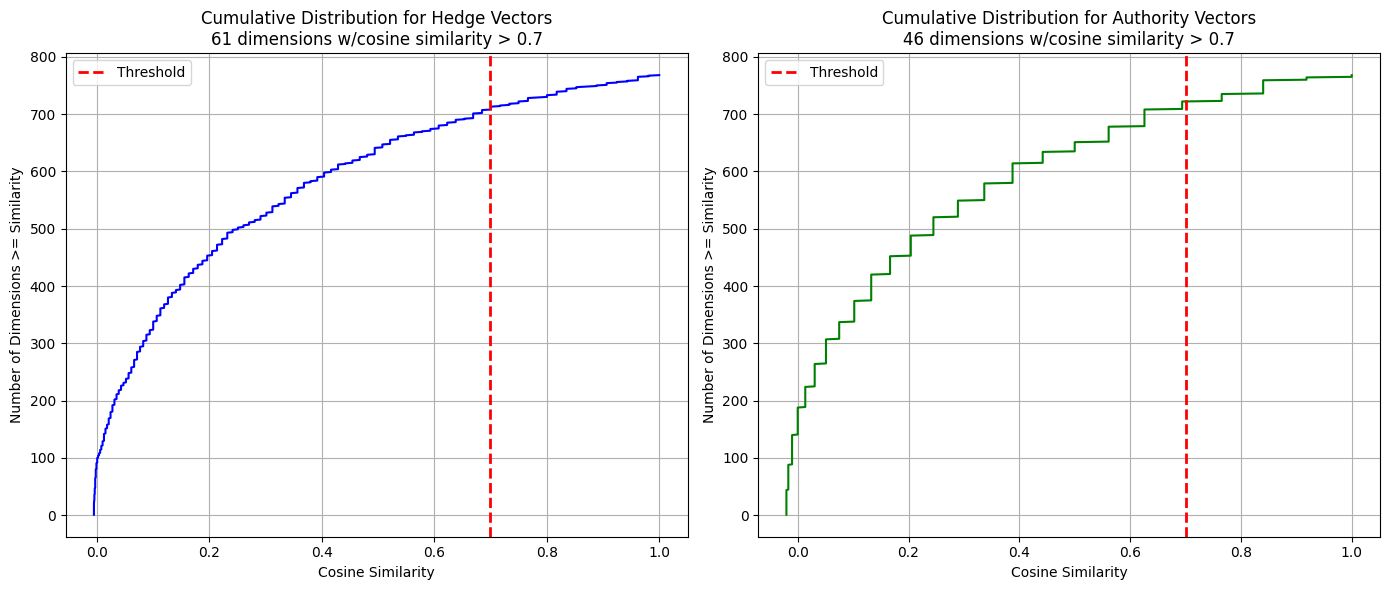

In [12]:
import matplotlib.pyplot as plt
from util_plotting import plot_cumulative_distribution

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot cumulative distribution for hedge vectors
plt.sca(axes[0])
plot_cumulative_distribution(dimension_similarities_hedge, 'Cumulative Distribution for Hedge Vectors', 'blue', threshold)

# Plot cumulative distribution for authority vectors
plt.sca(axes[1])
plot_cumulative_distribution(dimension_similarities_authority, 'Cumulative Distribution for Authority Vectors', 'green', threshold)

plt.tight_layout()
plt.show()

In [13]:
import numpy as np
from scipy.spatial.distance import cosine

def find_similar_ngrams(example, hedge_vectors, similar_dimensions, n=3, threshold=0.75):
    example_tokens = example['tokens']
    example_embeddings = example['embeddings']
    example_id = example['statement_id']
    similar_ngrams = []
    
    # Extract the embeddings for the similar dimensions
    example_embeddings_reduced = example_embeddings[:, similar_dimensions]
    
    def n_grams(tokens, embeddings, n):
        """Generate n-grams and their corresponding average embeddings."""
        for i in range(len(tokens) - n + 1):
            yield tokens[i:i+n], np.mean(embeddings[i:i+n], axis=0)
    
    for tokens, avg_embedding in n_grams(example_tokens, example_embeddings_reduced, n):
        similarity = 0
        for hedge_vector in hedge_vectors:
            hedge_vector_reduced = hedge_vector[similar_dimensions]
            similarity += (1 - cosine(avg_embedding, hedge_vector_reduced))
        if (similarity / len(hedge_vectors)) > threshold:
            similar_ngrams.append(" ".join(tokens))
    
    return similar_ngrams

# Example usage
threshold = 0.85

for example in data:
    # print(example['original_string'])
    similar_words = find_similar_ngrams(example, hedge_vectors, similar_dimensions_hedge, n = 1, threshold=threshold)
    if len(similar_words) > 0:
        print(similar_words)

['think']
['think']
['think']
['think']
['think']
['think']
['maybe']
['think']
['think']
['maybe']
['think']
['maybe']
['think']
['think']


KeyboardInterrupt: 

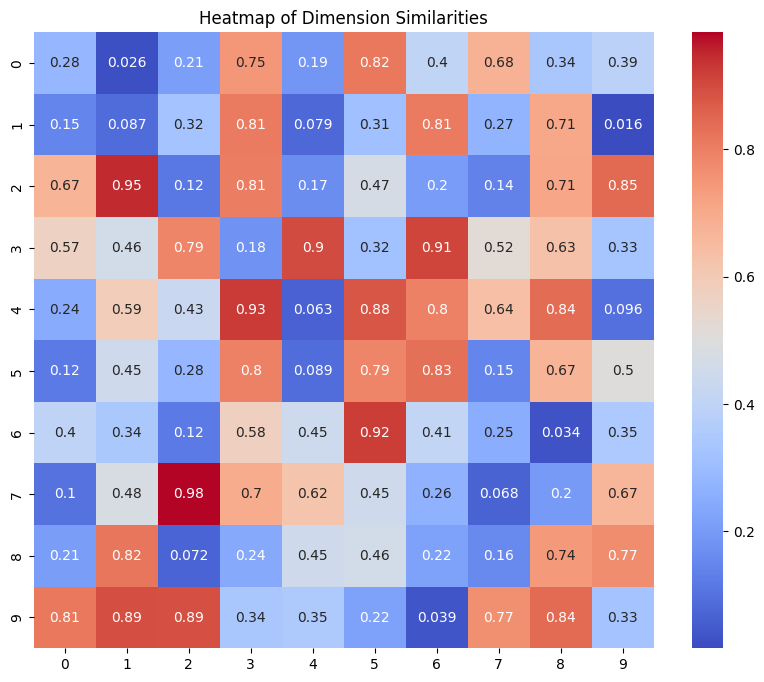

In [14]:
import seaborn as sns

# Generate a random similarity matrix for demonstration purposes
similarity_matrix = np.random.rand(10, 10)

# Plot a heatmap of the similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='coolwarm', annot=True)
plt.title('Heatmap of Dimension Similarities')
plt.show()

In [31]:
import json

# Load your JSON data
with open('data/human_annotated_dataset.json', 'r') as file:
    data = json.load(file)
print(len(data))
word = "know"
print(data[:1])
# Filter data to include entries where 'matched_terms' has 'know' as a key
filtered_data = [item for item in data if word in item['matched_terms']]
print(f"Instances of {word}: {len(filtered_data)}")
statements = []
# Optionally, print the filtered data to see the result
for item in filtered_data:
    # print(item)
    # Concatenate strings properly
    
    string = item["previous_statement"] + " statement: " + item["statement"]
    category = item["matched_terms"]["know"]
    # Remove '<' and '>' characters from the string
    string = string.replace("<", "")
    string = string.replace(">", "")
    statements.append((string, category, word))
print(len(filtered_data))

249
[{'transcript_id': 'NPR-43285', 'statement_id': 'da888b1e-0aab-4e40-b5b6-d8c8ddb0ca10', 'matched_terms': {'best': 'none', 'every': 'none', 'know': 'none', 'only': 'none', 'probably': 'hedge', 'maybe': 'hedge', 'thing': 'none'}, 'previous_statement': 'So you would just add a little as your life happened?', 'statement': "I was adding to it, and if it was funny and it was true, I      kept it.  And if it wasn't funny and people didn't respond to it, I      dropped it. And so it was really--you <KNOW>, it was performance art that I      just memorized the <BEST> parts of.  The <ONLY> <THING> I really miss <ABOUT>      doing it these days is that there's <<MAYBE>> a few people in <EVERY> crowd      that haven't heard it, but it's nothing like having the few hundred or a      few thousand people years and years ago--40 years ago--when nobody had      heard it.  Those moments can't be repeated. And not <ONLY> that, there were      people singing this song together who politically had noth

In [28]:
import numpy as np

def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

def identify_similar_parts(vectors, threshold=0.5):
    num_vectors = len(vectors)
    num_dimensions = len(vectors[0])
    
    # Initialize a list to hold the similarity for each dimension
    dimension_similarities = np.zeros(num_dimensions)
    
    # Compute the cosine similarity for each dimension across all pairs of vectors
    for i in range(num_vectors):
        for j in range(i + 1, num_vectors):
            vec1, vec2 = vectors[i], vectors[j]
            for k in range(num_dimensions):
                dim_vec1 = np.zeros(num_dimensions)
                dim_vec2 = np.zeros(num_dimensions)
                dim_vec1[k] = vec1[k]
                dim_vec2[k] = vec2[k]
                dimension_similarities[k] += cosine_similarity(dim_vec1, dim_vec2)
    
    # Average the similarity scores for each dimension
    dimension_similarities /= (num_vectors * (num_vectors - 1) / 2)
    
    # Identify dimensions with similarity above the threshold
    similar_dimensions = np.where(dimension_similarities > threshold)[0]
    
    return similar_dimensions, dimension_similarities

In [30]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine

# Load the pretrained BERT base uncased model and tokenizer
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

vectors = []
for statement in statements:
    sample_text = statement[0]
    classification = statement[1]
    word = statement[2]
    # Encode the text
    encoded_input = tokenizer(sample_text, return_tensors='pt')

    # Extract input ids and find the indices for "know"
    input_ids = encoded_input['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    token_indices = [i for i, token in enumerate(tokens) if token == 'know']

    # Get the model output
    try:
        output = model(**encoded_input)
    

        # Extract embeddings for "know"
        token_embeddings = output.last_hidden_state[0, token_indices, :] if token_indices else None
        if token_embeddings is not None:
            vectors.append((token_embeddings.mean(dim=0).detach(),classification, word))  # Average if multiple "know" tokens and detach
        else:
            vectors.append((None, None, None))  # No "know" found in this sample
    except:
        print("Skipping instance due to error.")

# Compute cosine similarity between all pairs of vectors
if len(vectors) > 1:
    for i in range(len(vectors)):
        for j in range(i + 1, len(vectors)):
            if vectors[i] is not None and vectors[j] is not None:
                cat1 = vectors[i][1]
                cat2 = vectors[j][1]
                word = vectors[i][2]
                similarity = 1 - cosine(vectors[i][0].numpy(), vectors[j][0].numpy())
                print(f"{word} {i+1},{j+1}: {cat1}/{cat2} Cosine similarity: {similarity:.4f}")
            else:
                print(f"One or both of the texts {i+1} and {j+1} do not contain the token 'know'.")

Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


Skipping instance due to error.
know 1,2: none/none Cosine similarity: 0.3371
know 1,3: none/none Cosine similarity: 0.4140
know 1,4: none/none Cosine similarity: 0.8217
know 1,5: none/authority Cosine similarity: 0.3975
know 1,6: none/none Cosine similarity: 0.3935
know 1,7: none/hedge Cosine similarity: 0.8402
know 1,8: none/none Cosine similarity: 0.7664
know 1,9: none/hedge Cosine similarity: 0.7378
know 1,10: none/none Cosine similarity: 0.6234
know 1,11: none/hedge Cosine similarity: 0.7828
know 1,12: none/none Cosine similarity: 0.8546
know 1,13: none/hedge Cosine similarity: 0.8527
know 1,14: none/hedge Cosine similarity: 0.8332
know 1,15: none/authority Cosine similarity: 0.6808
know 1,16: none/authority Cosine similarity: 0.8475
know 1,17: none/authority Cosine similarity: 0.8033
know 1,18: none/hedge Cosine similarity: 0.7494
know 1,19: none/hedge Cosine similarity: 0.8686
know 1,20: none/hedge Cosine similarity: 0.7740
know 1,21: none/none Cosine similarity: 0.4459
know 1,2

### This creates a cosine similarity matrix showing average cosine similarity between all of the instances of each type of word

In [36]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
import numpy as np
from collections import defaultdict
import pandas as pd

# Load the pretrained BERT base uncased model and tokenizer
model_name = "bert-base-uncased"
model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Prepare to collect vectors by classification
classification_vectors = defaultdict(list)

for statement in statements:
    sample_text = statement[0]
    classification = statement[1]
    word = statement[2]

    # Encode the text
    encoded_input = tokenizer(sample_text, return_tensors='pt')

    # Extract input ids and find the indices for the target token "know"
    input_ids = encoded_input['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    token_indices = [i for i, token in enumerate(tokens) if token == word][:1]

    # Get the model output
    try:
        output = model(**encoded_input)

        # Extract embeddings for the target token
        token_embeddings = output.last_hidden_state[0, token_indices, :] if token_indices else None
        if token_embeddings is not None:
            # Average if multiple target tokens and detach
            mean_embedding = token_embeddings.mean(dim=0).detach()
            classification_vectors[classification].append(mean_embedding)
    except Exception as e:
        print(f"Skipping instance due to error: {e}")

# Compute cosine similarities between different classifications
classifications = list(classification_vectors.keys())
print("classification_vectors length:", len(classification_vectors))
similarity_scores = defaultdict(dict)

for i, class1 in enumerate(classifications):
    for class2 in classifications[i:]:  # Compute for class1 vs class2 and avoid repeating with class2 vs class1
        vectors1 = classification_vectors[class1]
        vectors2 = classification_vectors[class2]
        total_similarity = 0
        count = 0
        
        for v1 in vectors1:
            for v2 in vectors2:
                if v1 is not None and v2 is not None:
                    total_similarity += 1 - cosine(v1.numpy(), v2.numpy())
                    count += 1
        
        # Avoid division by zero and only calculate if count is not zero
        average_similarity = total_similarity / count if count > 0 else 0
        similarity_scores[class1][class2] = average_similarity
        if class1 != class2:
            similarity_scores[class2][class1] = average_similarity  # Fill both [class1][class2] and [class2][class1]

# Convert the similarity scores into a DataFrame for better visualization
similarity_df = pd.DataFrame(similarity_scores).fillna('-')  # Fill missing values with '-'
print(similarity_df)

Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


Skipping instance due to error: The size of tensor a (590) must match the size of tensor b (512) at non-singleton dimension 1
classification_vectors length: 3
               none  authority     hedge
none       0.522874   0.526112  0.544508
authority  0.526112   0.648760  0.648817
hedge      0.544508   0.648817  0.737256
